In [1]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs6353/assignments/assignment1/'
# FOLDERNAME = 'assignment1'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# # This downloads the CIFAR-10 dataset to your Drive
# # if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME

# # Install requirements from colab_requirements.txt
# # TODO: Please change your path below to the colab_requirements.txt file
# ! python -m pip install -r /content/drive/My\ Drive/$FOLDERNAME/colab_requirements.txt

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:

from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs6353.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(cifar10_dir='cs6353/datasets/cifar-10-batches-py', num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

################################################################################
# TODO: Change the path of the CIFAR-10 data directory correctly to            #
# the correct location                                                         #
# Default path is set to cs6353/datasets/cifar-10-batches-py'                 #
################################################################################
cifar10_dir='cs6353/datasets/cifar-10-batches-py'
################################################################################
#                              END OF YOUR CODE                                #
################################################################################ 

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs6353.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs6353.classifiers.linear_classifier import LinearSVM

learning_rates = np.linspace(1e-7, 9e-7, 8)
regularization_strengths = np.linspace(3e4, 4e4, 3)
# learning_rates = [1e-9, 1e-8, 1e-7]
# regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifier in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for learn in learning_rates:
    for regular in regularization_strengths:
        new_svm = LinearSVM()
        new_svm.train(X_train_feats, y_train, learn, regular, num_iters=1500, verbose=True)
        y_train_pred = new_svm.predict(X_train_feats)
        y_val_pred = new_svm.predict(X_val_feats)
        train_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        if best_val < val_acc:
            best_val = val_acc
            best_svm = new_svm
        results[(learn, regular)] = (train_acc, val_acc)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 56.914025
iteration 100 / 1500: loss 23.376865
iteration 200 / 1500: loss 13.314719
iteration 300 / 1500: loss 10.295868
iteration 400 / 1500: loss 9.388885
iteration 500 / 1500: loss 9.115754
iteration 600 / 1500: loss 9.034414
iteration 700 / 1500: loss 9.009948
iteration 800 / 1500: loss 9.002526
iteration 900 / 1500: loss 9.000238
iteration 1000 / 1500: loss 8.999638
iteration 1100 / 1500: loss 8.999529
iteration 1200 / 1500: loss 8.999406
iteration 1300 / 1500: loss 8.999391
iteration 1400 / 1500: loss 8.999427
iteration 0 / 1500: loss 63.759720
iteration 100 / 1500: loss 22.434256
iteration 200 / 1500: loss 12.296035
iteration 300 / 1500: loss 9.809327
iteration 400 / 1500: loss 9.199019
iteration 500 / 1500: loss 9.047974
iteration 600 / 1500: loss 9.011490
iteration 700 / 1500: loss 9.002567
iteration 800 / 1500: loss 9.000141
iteration 900 / 1500: loss 8.999533
iteration 1000 / 1500: loss 8.999575
iteration 1100 / 1500: loss 8.999509
iteration 1200 / 1

iteration 500 / 1500: loss 8.999474
iteration 600 / 1500: loss 8.999472
iteration 700 / 1500: loss 8.999485
iteration 800 / 1500: loss 8.999387
iteration 900 / 1500: loss 8.999303
iteration 1000 / 1500: loss 8.999462
iteration 1100 / 1500: loss 8.999503
iteration 1200 / 1500: loss 8.999416
iteration 1300 / 1500: loss 8.999357
iteration 1400 / 1500: loss 8.999459
iteration 0 / 1500: loss 61.047953
iteration 100 / 1500: loss 9.002960
iteration 200 / 1500: loss 8.999483
iteration 300 / 1500: loss 8.999526
iteration 400 / 1500: loss 8.999423
iteration 500 / 1500: loss 8.999640
iteration 600 / 1500: loss 8.999425
iteration 700 / 1500: loss 8.999407
iteration 800 / 1500: loss 8.999497
iteration 900 / 1500: loss 8.999597
iteration 1000 / 1500: loss 8.999437
iteration 1100 / 1500: loss 8.999460
iteration 1200 / 1500: loss 8.999453
iteration 1300 / 1500: loss 8.999508
iteration 1400 / 1500: loss 8.999491
iteration 0 / 1500: loss 70.955597
iteration 100 / 1500: loss 9.000539
iteration 200 / 1500

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.424


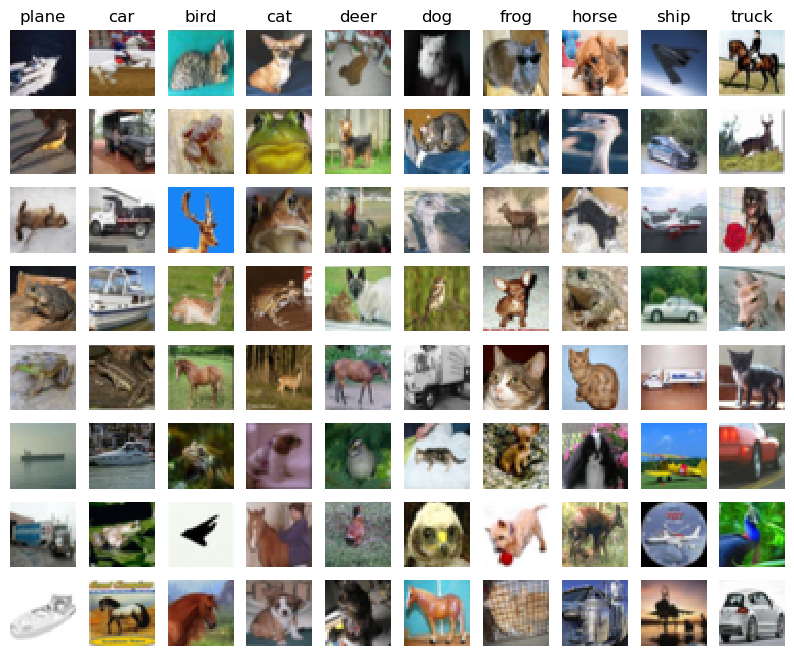

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

There are some very different pictures that are classified into the wrong categories. For example, under the category of birds, horse heads, cats, deer heads, and frogs appear, but they are all very blurry and noisy. For example, there are only photos of the head instead of the whole body, only the side profile and the strange pose of the animal while sleeping instead of the normal standing frontal image of the animal. In addition, very blurry images are also more likely to be misclassified.

## Neural Network on image features
Earlier in this assignment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [9]:
from cs6353.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

best_acc = 0.0
hidden_size = [50, 80, 110, 140]
num_classes = 10
learning_rate = [0.1, 0.2, 0.3]
batch_size = [200, 400, 600]
num_iters = [1500] 
reg = [1e-05, 1e-06, 1e-07]

for lr in learning_rate:
    for size in batch_size:
        for num in num_iters:
            for hi_size in hidden_size:
                for rag in reg:
                    net = TwoLayerNet(input_dim, hi_size, num_classes)
                    # Train the network
                    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                                num_iters=num, batch_size=size,
                                learning_rate=lr, learning_rate_decay=0.95,
                                reg=rag, verbose=False)
                    # Predict on the validation set
                    val_acc = (net.predict(X_val_feats) == y_val).mean()
                    if val_acc > best_acc:
                        best_acc = val_acc
                        best_net = net
                    print('Validation accuracy: ', val_acc, ' with learning_rate: ', lr, ' batch_size: ', size, ' num_iters: ', num, ' hidden_size: ', hi_size, ' reg: ', rag)
                    
                    # # Plot the loss function and train / validation accuracies
                    # plt.subplot(2, 1, 1)
                    # plt.plot(stats['loss_history'])
                    # plt.title('Loss history')
                    # plt.xlabel('Iteration')
                    # plt.ylabel('Loss')
                    # 
                    # plt.subplot(2, 1, 2)
                    # plt.plot(stats['train_acc_history'], label='train')
                    # plt.plot(stats['val_acc_history'], label='val')
                    # plt.title('Classification accuracy history')
                    # plt.xlabel('Epoch')
                    # plt.ylabel('Clasification accuracy')
                    # plt.legend()
                    # plt.show()

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Validation accuracy:  0.517  with learning_rate:  0.1  batch_size:  200  num_iters:  1500  hidden_size:  50  reg:  1e-05
Validation accuracy:  0.513  with learning_rate:  0.1  batch_size:  200  num_iters:  1500  hidden_size:  50  reg:  1e-06
Validation accuracy:  0.531  with learning_rate:  0.1  batch_size:  200  num_iters:  1500  hidden_size:  50  reg:  1e-07
Validation accuracy:  0.516  with learning_rate:  0.1  batch_size:  200  num_iters:  1500  hidden_size:  80  reg:  1e-05
Validation accuracy:  0.517  with learning_rate:  0.1  batch_size:  200  num_iters:  1500  hidden_size:  80  reg:  1e-06
Validation accuracy:  0.524  with learning_rate:  0.1  batch_size:  200  num_iters:  1500  hidden_size:  80  reg:  1e-07
Validation accuracy:  0.525  with learning_rate:  0.1  batch_size:  200  num_iters:  1500  hidden_size:  110  reg:  1e-05
Validation accuracy:  0.523  with learning_rate:  0.1  batch_size:  200  num_iters:  1500  hidden_size:  110  reg:  1e-06
Validation accuracy:  0.521  w

Validation accuracy:  0.571  with learning_rate:  0.2  batch_size:  600  num_iters:  1500  hidden_size:  110  reg:  1e-07
Validation accuracy:  0.56  with learning_rate:  0.2  batch_size:  600  num_iters:  1500  hidden_size:  140  reg:  1e-05
Validation accuracy:  0.564  with learning_rate:  0.2  batch_size:  600  num_iters:  1500  hidden_size:  140  reg:  1e-06
Validation accuracy:  0.563  with learning_rate:  0.2  batch_size:  600  num_iters:  1500  hidden_size:  140  reg:  1e-07
Validation accuracy:  0.535  with learning_rate:  0.3  batch_size:  200  num_iters:  1500  hidden_size:  50  reg:  1e-05
Validation accuracy:  0.539  with learning_rate:  0.3  batch_size:  200  num_iters:  1500  hidden_size:  50  reg:  1e-06
Validation accuracy:  0.546  with learning_rate:  0.3  batch_size:  200  num_iters:  1500  hidden_size:  50  reg:  1e-07
Validation accuracy:  0.569  with learning_rate:  0.3  batch_size:  200  num_iters:  1500  hidden_size:  80  reg:  1e-05
Validation accuracy:  0.555  

In [10]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.57
